I was recently trying to embed a clip in a jupyter notebook using [https://github.com/Zulko/moviepy](MoviePy), somthing that was working smoothly with python 2.7. After switching to python 3, this was not working anymore and left me scratcthing my head for a solution.

We live in a open-sourced world, so I filled an issue: 

https://github.com/Zulko/moviepy/issues/160

<!-- TEASER_END -->

which basically describes the problem:

using a video clip generated by:

````
duration = 20.
fig_mpl, ax = plt.subplots(1, figsize=(6, 5), facecolor='white')

def draw_elementary_pattern(ax, center):
    ax.add_artist(mpl.patches.Wedge(center, 1., 0, 180, width=.1))

def make_frame_mpl(t):
    ax.cla()
    draw_elementary_pattern(ax, t/duration)
    return mplfig_to_npimage(fig_mpl) # RGB image of the figure

animation = mpy.VideoClip(make_frame_mpl, duration=duration)
````
I am trying to embed it in the notebook using:

````
mpy.ipython_display("circles.mp4", fps=20, loop=1, autoplay=1)
````

This was working nicely when I was using python 2, but seems to be broken when using python 3:

(The video generated by
````
animation.write_videofile("circles.mp4", fps=20)
````
would show fine in the browser when opened directly)


````
$ python3 --version
Python 3.4.3

$ ipython --version
3.1.0
````
any clue?


![screen shot 2015-04-25 at 16 26 43](https://cloud.githubusercontent.com/assets/381808/7333248/53c10966-eb68-11e4-93b8-4fa57a259d37.png)

Let's try to solve this step by step.

In [3]:
!pip install moviepy

  Using cached moviepy-0.2.2.11.tar.gz
  Using cached decorator-3.4.2.tar.gz
  Using cached imageio-1.2.tar.gz
  Using cached tqdm-1.0.tar.gz
  Running setup.py install for decorator
  Running setup.py install for imageio
  Running setup.py install for tqdm
  Running setup.py install for moviepy


In [4]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from moviepy.video.io.bindings import mplfig_to_npimage
import moviepy.editor as mpy

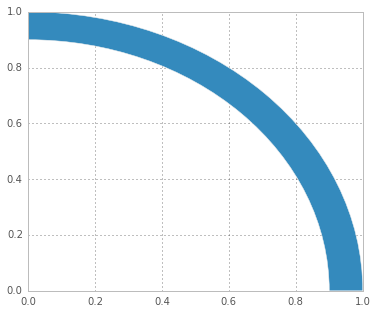

In [5]:
duration = 3.
fig_mpl, ax = plt.subplots(1, figsize=(6, 5), facecolor='white')

def draw_elementary_pattern(ax, center):
    ax.add_artist(mpl.patches.Wedge(center, 1., 0, 180, width=.1))

def make_frame_mpl(t):
    ax.cla()
    draw_elementary_pattern(ax, t/duration)
    return mplfig_to_npimage(fig_mpl) # RGB image of the figure

animation = mpy.VideoClip(make_frame_mpl, duration=duration)

Great. Now the following code should embed the movie in the notebook:

In [6]:
animation.ipython_display(fps=20, loop=1, autoplay=1)

Dooh! Something seems wrong - let's check the raw video file:

In [7]:
fname = "/tmp/circle.mp4"
animation.write_videofile(fname, fps=20)
mpy.ipython_display(fname, fps=20, loop=1, autoplay=1)

[MoviePy] >>>> Building video /tmp/circle.mp4
[MoviePy] Writing video /tmp/circle.mp4
[MoviePy] Done.
[MoviePy] >>>> Video ready: /tmp/circle.mp4 



But this video plays fine in my browser (Firefox on a Mac), so something must be wrong in the embedding.

As Zulko noted in the issue's discussion, he is using something like (see https://github.com/Zulko/moviepy/blob/master/moviepy/video/io/html_tools.py):

In [9]:
def video(fname, mimetype):
    """Load the video in the file `fname`, with given mimetype, and display as HTML5 video.
    """
    from IPython.display import HTML
    from base64 import b64encode    
    with open(fname, "rb") as f: 
        video_encoded= b64encode(f.read())
    video_tag= """
<center><video controls style='max-width:100%'>
<source src='data:{mimetype};base64,{b64}' type='video/{mimetype}' loop=1 autoplay>
Your browser does not support the video tag.
</video><center/>""".format(mimetype=mimetype, b64=video_encoded)
    return HTML(data=video_tag)
video(fname, fname.split('.')[-1])

I remembered during the switch to python3 the different things to change ``print()``, ``Except`` and... something around strings that become bytes objects (see https://docs.python.org/3.4/library/base64.html). I also remembered that the excellent [https://github.com/ioam/holoviews](holoviews) library as no problem to embed videos in the notebook. Dwelling in their code (see in particular https://github.com/ioam/holoviews/blob/master/holoviews/plotting/__init__.py and https://github.com/ioam/holoviews/blob/master/holoviews/ipython/display_hooks.py) I could find this particular solution working:

In [15]:
def video(fname, mimetype):
    """Load the video in the file `fname`, with given mimetype, and display as HTML5 video.
    """
    from IPython.display import HTML
    from base64 import b64encode
    
    with open(fname, "rb") as f: 
        video_encoded = b64encode(f.read()).decode("utf-8")

    video_tag= """
<center><video controls style='max-width:100%'>
<source src='data:{mimetype};base64,{b64}' type='video/{mimetype}' loop=1 autoplay=1>
Your browser does not support the video tag.
</video><center/>""".format(mimetype=mimetype, b64=video_encoded)
    return HTML(data=video_tag)

video(fname, fname.split('.')[-1])

Works as expected! Let's try to do a pull request

- set-up variables

       cd ~/pool/libs/
       github_user='laurentperrinet'
       lib='moviepy'
       project='moviepy3'
       git clone https://github.com/$github_user/$lib
       cd $lib
       

-  creating a new branch for his project

       git branches
       git remote add $github_user https://github.com/$github_user/$lib
       git checkout -b $project

- making the one line change to moviepy's code and test it with the minimum working example above:

       vim moviepy/video/io/html_tools.py
       pip install -U .

-  publishing results

       git status
       git commit -am"fix to work with python3"
       git push $github_user $project


-  confirm the pull request

       open https://github.com/$github_user/$lib

-  come back to the ``master`` branch

       git checkout master

